# Amazon Bedrock - Latency Benchmark Tool
This notebook contains a set of tools to benchmark inference latency for Foundation Models available in Amazon Bedrock. 

You can evaluate latency for different scenarios such as comparison between use cases, regions, and models, including models from 3rd-party platforms like OpenAI's GPT-4.

To run this notebook you will need to have the appropriate access to Amazon Bedrock, and previously enabled the models from the Amazon Bedrock Console. 

## Examples included in this notebook
1. [Use Case Comparison](#uc-compare) - Compare the latency of a given model across different LLM use cases (e.g., Summarization and classification).
2. [Region Comparison](#region-compare) - Comparing latency between two different models.
3. [Model Comparison](#model-compare) - Comparing the latency of a given model across different AWS regions.

### Install needed dependencies
Note: This notebook requires a basic Python 3 environment (e.g, `Base Python 3.0` in SageMaker Studio Notebooks)

### Create OpenAI API key (if measuring OpenAI models)

- Create a new file called `utils/key.py` in your project directory to store your API key.

- Do **not** commit `key.py` to source control, as it contains sensitive information. **Add `*key.py` to `.gitgnore`.** Review [this information about API safety](https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety).

- Go to your OpenAI account and navigate to "[View API keys](https://platform.openai.com/account/api-keys)."

- Select "Create new secret key."

- Copy the key and insert it into your file `utils/key.py` like this:
```
OPENAI_API_KEY = 'sk-actualLongKeyGoesHere123'
```

- Save the changes

In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet --upgrade boto3 awscli matplotlib numpy pandas nbdime anthropic openai

In [2]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('utils.utils')
logger.setLevel(logging.INFO) # <-- Change to DEBUG to troubleshoot errors

from utils.utils_claude3 import benchmark, create_prompt, execute_benchmark, get_cached_client, post_iteration, graph_scenarios_boxplot
import matplotlib.pyplot as plt

## Scenario keys and configurations

Each scenario is a dictionary with latency relevant keys:

| Key | Definition |
|-|-|
| `model_id` | The Bedrock model_id (like `anthropic.claude-v2`) or OpenAI model name (like `gpt-4-1106-preview`) to test. Smaller models are likely faster. Currently only Anthropic and OpenAI's GPT models are supported. |
| `in_tokens` | The number of tokens to feed to the model (input context length). The range depends on the model_id. For example: 40 - 100K for Claude-2. |
| `out_tokens` | The number of tokens for the model to generate. Range: 1 - 8191. |
| `region` | The AWS region to invoke Bedrock in. This can affect network latency depending on client location. |
| `stream` | True&#124;False - A streaming response starts returning tokens to the client as they are generated, instead of waiting before returning the complete responses. This should be True for interactive use cases.|
| `name` | A human readable name for the scenario (will appear in reports and graphs). |

Each scenario also has a benchmark configuration you can modify:

| Key | Definition |
|-|-|
| `invocations_per_scenario` | The number of times to benchmark each scenario. This is important in measuring variance and average response time across a long duration. |
| `sleep_between_invocations` | Seconds to sleep between each invocation. (0 is no sleep). Sleeping between invocation can help you measure across longer periods of time, and/or avoid throttling.|

## Example 1. Simulated LLM Use Case Performance Analysis
<a id="uc-compare"></a>

This section illustrates a comparative analysis of model latency in simulated LLM scenarios. Rather than actual prompt engineering, we use token count variations to represent different use cases. Here's how:

1. **Simulated Summarization Scenario**: This mimics a scenario where a lengthy input is condensed into a brief summary. We simulate this with 2000 `in_tokens` for input and 200 `out_tokens` for output.

2. **Simulated Classification Scenario**: Here, the scenario represents processing a medium to lengthy input to categorize into a single class. For simulation, it involves 400 `in_tokens` and just 1 `out_token`.

These scenarios are adjustable to align with your specific use cases.

In [29]:
use_cases_scenarios = [
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens'  : 2000,
                'out_tokens' : 200,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'Summarization',
            },
            {
                'model_id'    : 'anthropic.claude-3-sonnet-20240229-v1:0',
                'in_tokens' : 400,
                'out_tokens' : 1,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'Classification',
            }
]

scenario_config = {
    "invocations_per_scenario" : 10,
    "sleep_between_invocations": 5
}

In [30]:
scenarios = execute_benchmark(use_cases_scenarios, scenario_config, early_break = False)

INFO:utils.utils_claude3:About to execute scenario: [anthropic.claude-v2 in=2000, out=200
INFO:utils.utils_claude3:Scenario: [anthropic.claude-v2 in=2000, out=200, invocation: { 'time-to-first-token': 1,
  'time-to-last-token': 4,
  'timestamp_iso': '2024-03-12T05:48:40Z'}
INFO:utils.utils_claude3:Sleeping for 5 seconds.
INFO:utils.utils_claude3:About to execute scenario: [anthropic.claude-v2 in=2000, out=200
INFO:utils.utils_claude3:Scenario: [anthropic.claude-v2 in=2000, out=200, invocation: { 'time-to-first-token': 1,
  'time-to-last-token': 4,
  'timestamp_iso': '2024-03-12T05:48:50Z'}
INFO:utils.utils_claude3:Sleeping for 5 seconds.
INFO:utils.utils_claude3:About to execute scenario: [anthropic.claude-v2 in=2000, out=200
INFO:utils.utils_claude3:Scenario: [anthropic.claude-v2 in=2000, out=200, invocation: { 'time-to-first-token': 1,
  'time-to-last-token': 5,
  'timestamp_iso': '2024-03-12T05:49:00Z'}
INFO:utils.utils_claude3:Sleeping for 5 seconds.
INFO:utils.utils_claude3:About 

#### Analyze results 
The results show should show that summarization has a higher latency than classification due to the smaller number of input and output tokens.  
Note: Learn more on how to read boxplots [here](https://builtin.com/data-science/boxplot)

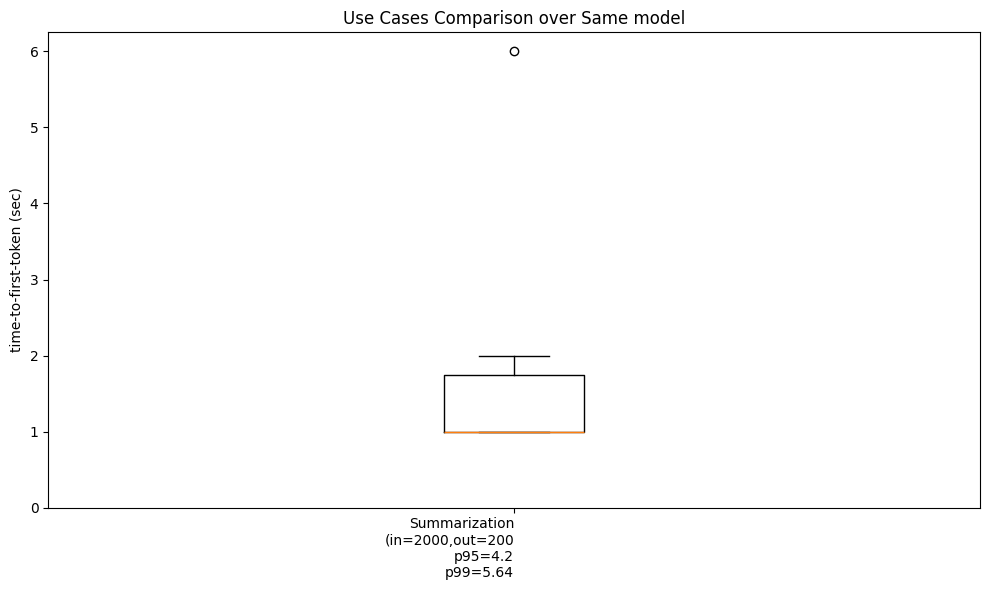

In [28]:
graph_scenarios_boxplot(
    scenarios=scenarios, 
    title="Use Cases Comparison over Same model"
)

## Example 2. Model Comparison
<a id="model-compare"></a>
Here we'll be comparing the latency of these models: 
- Bedrock
    - `anthropic.claude-v2` 
    - `anthropic.claude-instant-v1`
    - `ai21.j2-mid-v1`
    - `amazon.titan-text-express-v1`
- OpenAI
    - `gpt-4`
    - `gpt-4-1106-preview`
    - `gpt-3.5-turbo`



In [ ]:
model_compare_scenarios = [
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens'  : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'claude-v2',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'claude-instant-v1',
            },
            {
                'model_id'    : 'gpt-4',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'stream' : True,
                'name' : f'gpt-4',
            },
            {
                'model_id'    : 'gpt-4-1106-preview',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'stream' : True,
                'name' : f'gpt-4-turbo',
            },
            {
                'model_id'    : 'gpt-3.5-turbo',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'stream' : True,
                'name' : f'gpt-3.5-turbo',
            },
            {
                'model_id'    : 'ai21.j2-mid-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : False,
                'name' : f'ai21.j2-mid-v1',
            },
            {
                'model_id'    : 'amazon.titan-text-express-v1', # or us a fine tuned model arn
                'in_tokens'  : 200,
                'out_tokens' : 5,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'titan',
            },
]

scenario_config = {
    "invocations_per_scenario" : 3,
    "sleep_between_invocations": 5,
}

In [ ]:
scenarios = execute_benchmark(model_compare_scenarios, scenario_config, early_break = False)

### Results

In [ ]:
graph_scenarios_boxplot(
    scenarios=scenarios, 
    title="Model Comparison"
)


## Example 3. Region Comparison
<a id="region-compare"></a>
Here we'll be comparing the latency of a given model_id across three different AWS regions. Different regions resides in different timezone, and the load on each region can depend on the time of day.
> **🚨 ALERT 🚨** Remember to enable the models in **all regions** you wish to test. 
You can learn how to manage model access in the following [page](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html#manage-model-access).


In [ ]:
region_compare_scenarios = [
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens'  : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'us-east-1',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-west-2',
                'stream' : True,
                'name' : f'us-west-2',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'eu-central-1',
                'stream' : True,
                'name' : f'eu-central-1',
            }
]

scenario_config = {
    "invocations_per_scenario" : 2,
    "sleep_between_invocations": 5
}

In [ ]:
scenarios = execute_benchmark(region_compare_scenarios, scenario_config, early_break = False)

### Results
We don't apriori expect a particular region to be faster than others in a significant way. 

In [ ]:
graph_scenarios_boxplot(
    scenarios=scenarios, 
    title="Regions Comparison"
)

# Done